# **Deep Learning Term Project Part-B: Team 02**

## Calling Libraries

In [17]:
%%capture
!pip install accelerate -U
!pip install transformers[torch]
!pip install datasets
!pip install pycocoevalcap

import os
import torch
import pandas as pd
from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset
from transformers import ViTImageProcessor, BertTokenizer, GPT2Tokenizer

## Calling Data

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
!unzip '/content/drive/MyDrive/Ass2/custom_captions_dataset.zip'

Archive:  /content/drive/MyDrive/Ass2/custom_captions_dataset.zip
replace custom_captions_dataset/train/train_3.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# # Define the model

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torchvision import models

# # Use a pretrainined vision transformer model as encoder and GPT2 as decoder
# # Define a custom image captioning models whose parameters can be trained

# class ImageCaptioningModel(nn.Module):
#     def __init__(self, encoder, decoder, vocab_size):
#         super(ImageCaptioningModel, self).__init__()
#         self.encoder = encoder
#         self.decoder = decoder
#         self.vocab_size = vocab_size
#         self.fc = nn.Linear(768, vocab_size)

#     def forward(self, image, caption):
#         # Encode the image
#         image_features = self.encoder(image)
#         # Decode the image features
#         caption_logits = self.decoder(caption)
#         return caption_logits

#     def caption_image(self, image, max_length=50):
#         result_caption = []
#         with torch.no_grad():
#             x = self.encoder(image).unsqueeze(0)
#             for _ in range(max_length):
#                 caption_logits = self.decoder(x)
#                 predicted_token = caption_logits.argmax(2)[:,-1].item()
#                 result_caption.append(predicted_token)
#                 x = torch.cat((x, self.decoder.embed_tokens(torch.tensor(predicted_token).unsqueeze(0))), dim=1)
#                 if predicted_token == self.decoder.eos_token_id:
#                     break
#         return result_caption

# # Load the encoder and decoder
# from transformers import ViTImageProcessor, GPT2TokenizerFast
# encoder = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
# decoder = GPT2TokenizerFast.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
# vocab_size = len(vocab)
# model = ImageCaptioningModel(encoder, decoder, vocab_size)



In [32]:
from torch.utils.data import Dataset

# Class for image captioning
class ImageCaptionDataset(Dataset):
    def __init__(self, csv, image_dir, transform=None, max_length=128):
        self.img_labels = pd.read_csv(csv)
        self.img_dir = image_dir
        self.transform = transform
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')   ## Uncomment this and commen next to use gpt2 tokenizer
        # self.tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        self.image_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
        self.max_length = max_length

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1])
        image = Image.open(img_path).convert('RGB')
        caption = self.img_labels.iloc[idx, 2]

        if self.transform:
            image = self.transform(image)
        else:
            image = self.image_processor(images=image, return_tensors="pt").pixel_values.squeeze(0)

        tokens = self.tokenizer(caption, max_length=self.max_length, padding='max_length', truncation=True, return_tensors="pt")
        input_ids = tokens.input_ids.squeeze(0)

        return {
            'pixel_values': image,
            'labels': input_ids,
        }


In [33]:
# Calling the training and validation dataset

train_dataset = ImageCaptionDataset(csv='/content/custom_captions_dataset/train.csv', image_dir='/content/custom_captions_dataset/train/')
val_dataset = ImageCaptionDataset(csv='/content/custom_captions_dataset/val.csv', image_dir='/content/custom_captions_dataset/val/')

## Model

In [34]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [39]:
from transformers import ViTImageProcessor, BertTokenizer, GPT2Tokenizer, VisionEncoderDecoderModel
from datasets import load_dataset

image_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
# tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained("google/vit-base-patch16-224-in21k", "google-bert/bert-base-uncased")
# model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained("google/vit-base-patch16-224-in21k", "gpt2")

model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id

Some weights of BertLMHeadModel were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.bi

## Training the model

In [ ]:
# # Train the model

# def train(model, train_loader, criterion, optimizer, num_epochs):
#     model.train()
#     for epoch in range(num_epochs):
#         running_loss = 0.0
#         for i, data in enumerate(train_loader, 0):
#             images, captions = data
#             optimizer.zero_grad()
#             image_features, caption_output = model(images, captions)
#             loss = criterion(caption_output, captions)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()
#             if i % 2000 == 1999:
#                 print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
#                 running_loss = 0.0
#     print('Finished Training')

# # Train the model
# train(model, train_loader, criterion, optimizer, num_epochs=5)



In [40]:
# Specifying training arguments for the model

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="steps",
    logging_dir='./logs',
    num_train_epochs=5,
    eval_steps=50,
    logging_steps=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    weight_decay=0.01,
    warmup_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model='loss',
)

In [41]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=None,
)


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [42]:
# Training the model

trainer.train()

Removed shared tensor {'decoder.cls.predictions.decoder.weight', 'decoder.cls.predictions.decoder.bias'} while saving. This should be OK, but check by verifying that you don't receive any warning while reloading


There were missing keys in the checkpoint model loaded: ['decoder.cls.predictions.decoder.weight', 'decoder.cls.predictions.decoder.bias'].


TrainOutput(global_step=1790, training_loss=1.7017991524168898, metrics={'train_runtime': 3852.7699, 'train_samples_per_second': 7.417, 'train_steps_per_second': 0.465, 'total_flos': 5.172825055897498e+18, 'train_loss': 1.7017991524168898, 'epoch': 5.0})

## Evaluating Model

In [43]:
model = model.eval()

In [44]:
# # generate some captions without Training
# import random
# import numpy as np
# from PIL import Image
# import torchvision.transforms as transforms

# def transform(image):
#     transform = transforms.Compose([
#         transforms.Resize((299, 299)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ])
#     return transform(image)

# def generate_caption(model, image_path):
#     image = Image.open(image_path)
#     image = transform(image).unsqueeze(0)
#     caption = model.caption_image(image)
#     caption = [vocab.itos[token] for token in caption]
#     return caption




In [45]:
# Function for generating caption

def captionGenerator(img_path, model, image_processor, tokenizer, device):

    img = Image.open(img_path).convert('RGB')
    val = image_processor(images=img, return_tensors="pt").pixel_values.to(device)

    outputs = model.generate(val, max_length=128, decoder_start_token_id=model.config.decoder_start_token_id)

    captions = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    # return the first caption generated
    return captions[0]

In [46]:
# Generating captions from the test set using the trained model
test_image_dir = '/content/custom_captions_dataset/test/'
test_labels = pd.read_csv('/content/custom_captions_dataset/test.csv')

predictions = []
for idx in tqdm(range(len(test_labels)), desc="Generating captions"):
    img_path = os.path.join(test_image_dir, test_labels.iloc[idx, 1])
    pred = captionGenerator(img_path, model, image_processor, tokenizer, device)
    predictions.append(pred)

Generating captions: 100%|██████████| 928/928 [29:35<00:00,  1.91s/it]


In [57]:
test_labels['Predictions'] = predictions

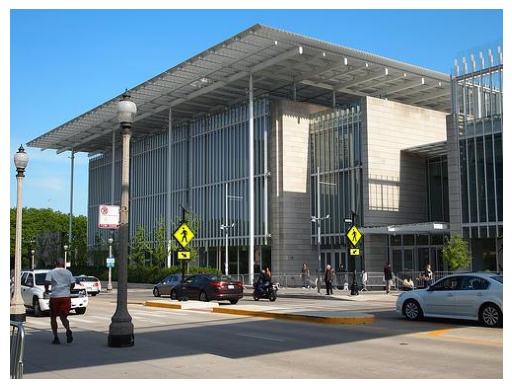


Original caption: A large building with bars on the windows in front of it. There is people walking in front of the building. There is a street in front of the building with many cars on it. 
Generated caption: a large red and white fire hydrant is parked on a sidewalk in front of a building. there is a large white building behind the fire hydrant. there is a large white building behind the fire hydrant.



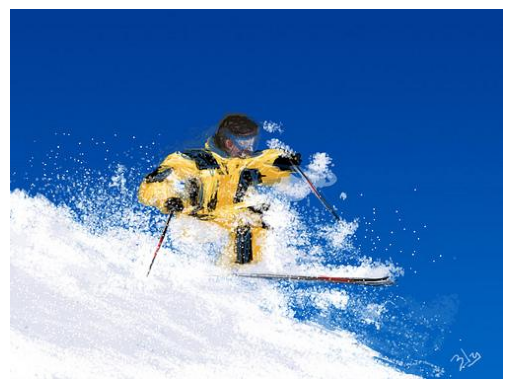


Original caption: A person is skiing through the snow. There is loose snow all around them from him jumping. The person is wearing a yellow snow suit. The person is holding two ski poles in their hands. 
Generated caption: a person is standing on skis. the person is wearing a black jacket. the person is holding a ski pole. the person is wearing a black helmet. the helmet is black. the person is holding a ski pole. the person is wearing a black helmet. the person is wearing a black helmet. the person is holding a ski pole. the person is wearing a black jacket.



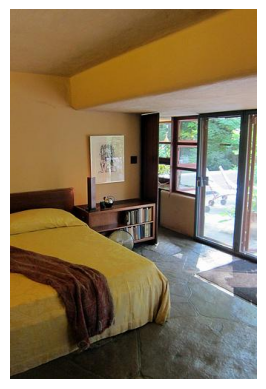


Original caption: There is a bed in a room against a wall. There is a brown blanket on top of the bed. There is a small brown book shelf next to the bed. There is a picture hanging on the wall above the shelf. 
Generated caption: a bed is in a room. there is a window on the wall. there is a lamp on top of the bed. there is a window next to the bed. there is a white door on the door. there is a white door to the right of the bed. there is a window on the wall. there is a white curtain on the window. there is a white door to the right of the bed.



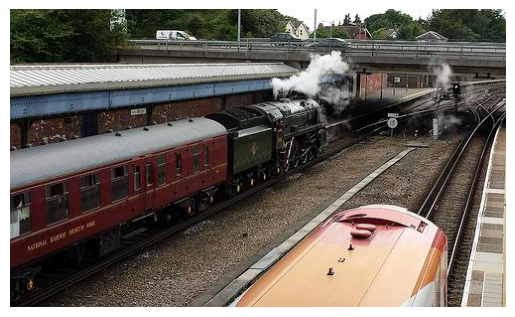


Original caption: A black and red train is on the tracks and has steam coming out off of it. There is another train next to the first train that is orange. There is an overpass over the train tracks with cars on it. 
Generated caption: a train is on the tracks. the train is red and white. there are people standing on the platform. there are people standing on the platform.



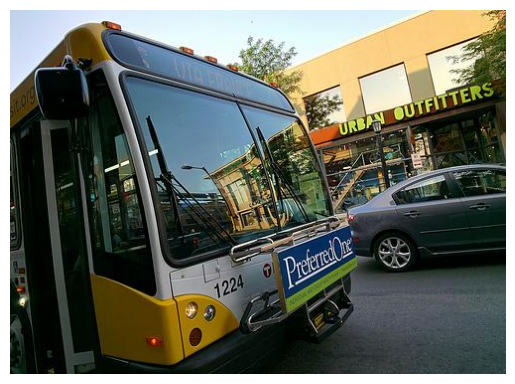


Original caption: A white and yellow public transportation bus with "122" on front is stopped with it's doors open. There is a gray car on the street beside the bus. Behind the car there is a  building with an "Urban Outfitters" on the first floor.
Generated caption: a bus is parked on the street. the bus is white. the bus is red. the bus is white. the bus is parked on the sidewalk. the bus is white. the bus is parked on the sidewalk. the bus is white. the bus is parked on the sidewalk. the bus is white. the bus is parked on the sidewalk. the bus is white. the bus is white. the bus is parked on the sidewalk.



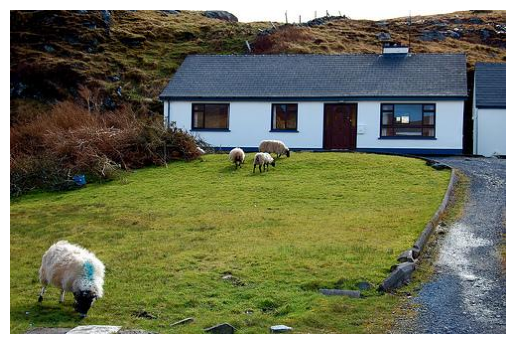


Original caption: A large white house with a brown door sits behind some grass. There are four sheep grazing on the grass in front of the house. The house ahs a gray roof. 
Generated caption: a sheep is standing in the grass. the sheep is white and has a black collar. the sheep has a black collar. there is a fence behind the sheep.



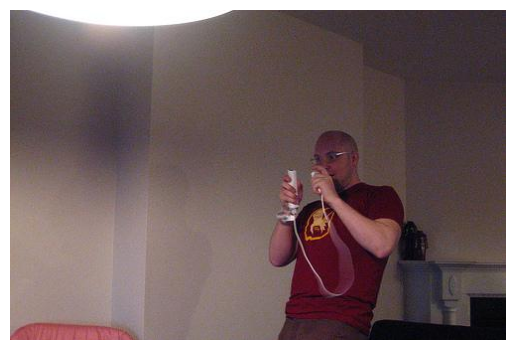


Original caption: A man in a red and yellow t-shirt is holding a Wii remote in each of his hands. Behind him there is a fireplace which has been painted white. In front of him a light which is on and illuminating the room. 
Generated caption: a man is sitting in a chair. he is wearing a black shirt and a tie. there is a television on the wall behind him.



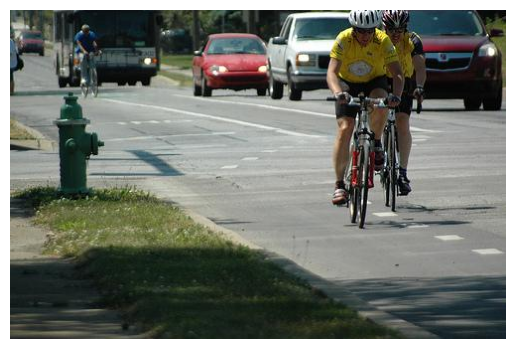


Original caption: There are three men riding bicycles. Two of the men are wearing yellow and the third man has a blue shirt. The two men are way ahead of the third man. The men are bicycling in the bicycle lane. The cars are on the left side of the men.
Generated caption: a person is riding a bike down a road. the person is wearing a helmet. the helmet is black. there are cars on the road. there are trees on the side of the road. there are cars parked on the road. there are cars parked on the road. there are cars parked on the street. there are cars parked on the street. there are cars parked on the street. there are many trees on the side of the road. there are many cars on the road. there are many buildings on the side of the road. there are many trees on the other side of the road.



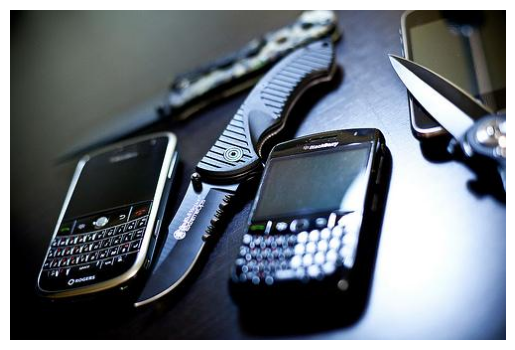


Original caption: TWO CELL PHONES ON THE TABLE.THEY BOTH ARE DARK IN COLOR A ND ARE BLACBERRYS.THERE ARE THREE CUTTING KNIVES.ONE KNIFE IS BETWEEN THE TWO PHONES.THERE IS A THIRD PHONE WITH A KNIFE LYING OVER IT.
Generated caption: a silver mouse is sitting on top of a desk. the mouse is black and silver. there is a black mouse next to the mouse.



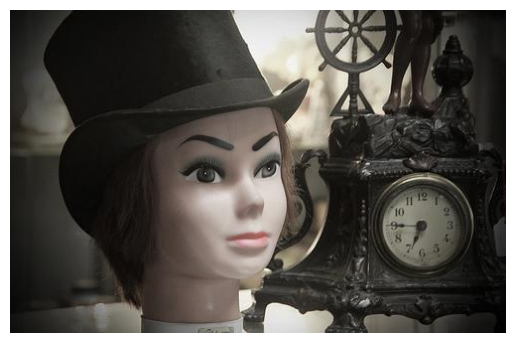


Original caption: A painted mannequin head sits on a table. It is a feminine head with arched eyebrows a small nose, big eyes and it is wearing a black top hat and a brown wig. To the right of the head is a metal sculpture clock with a white face.
Generated caption: a woman is standing in front of a clock. the clock is black and has a white face. the woman is wearing a black hat.



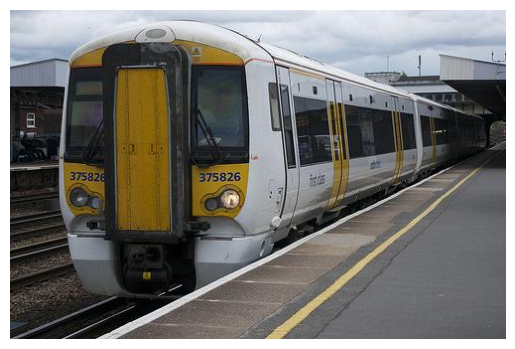


Original caption: A white and yellow train is on the tracks. There is a large yellow door on the front of the train. There is a platform next to the train. 
Generated caption: a train is on the tracks. the train is white. the train is on the tracks. the train is gray. the train is gray. the train is on the tracks. the train is gray. the train is on the tracks. the train is gray. the train is gray. the train is on the tracks. the train is white. there are wires on the roof of the train.



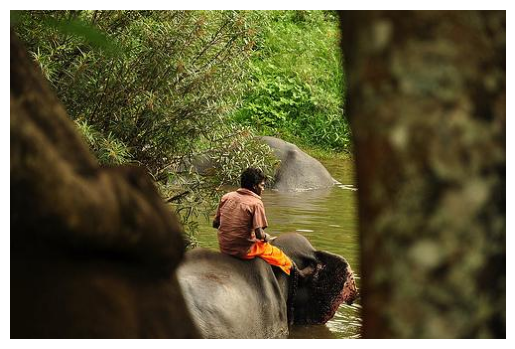


Original caption: A man is sitting on the back of an elephant. They are walking through a very high swamp area. They are being seen from in between the perspective of two logs of a tree.
Generated caption: a man is standing on a grassy field. he is wearing a short sleeve shirt and a short sleeve shirt. the man is holding a large brown elephant in his hand. the elephant has a long trunk. the man is wearing a long sleeve shirt. the man is wearing a black hat. the man has a beard. the man has a beard. the man has a beard. the man has a beard.



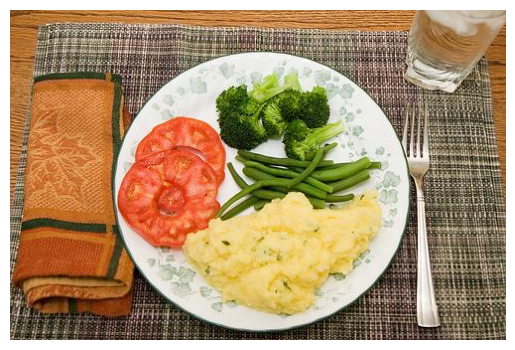


Original caption: There is a black place mat on top of a wood table. There is a white plate on the mat with food on it. There is a fork on the mat next to the plate. There is an orange towel next to the plate. 
Generated caption: a plate of food sits on a table. there is a sandwich on the plate. there is a fork on the table. there is a fork on the table.



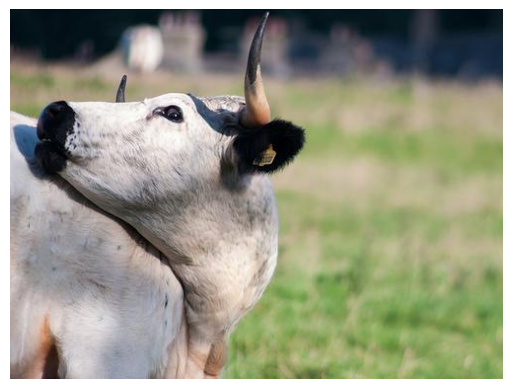


Original caption: A goat has its head turned back and it's looking at something. The goat is white but has a black nose and mouth and black ears. The horns of the goat are pointed upwards and has black tops. The goat is standing in green grass.
Generated caption: 



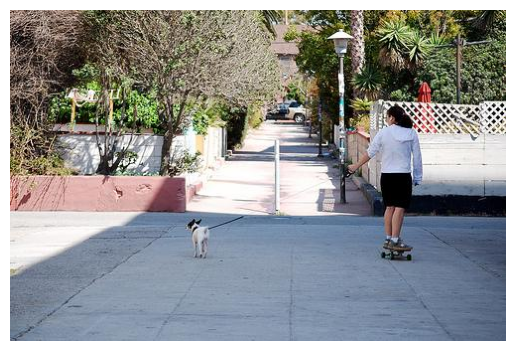


Original caption: A woman is walking her dog. She is on a skateboard while she is holding the leash of her dog. She is wearing a gray hoodie and some black shorts.
Generated caption: a man is skateboarding on a concrete ramp. he is wearing a short sleeve shirt and jeans. the man is wearing a pair of shorts and a pair of sneakers. the man is wearing a pair of jeans and a pair of sneakers. there are trees in the background of the photo. there are buildings in the background. there are buildings in the distance.



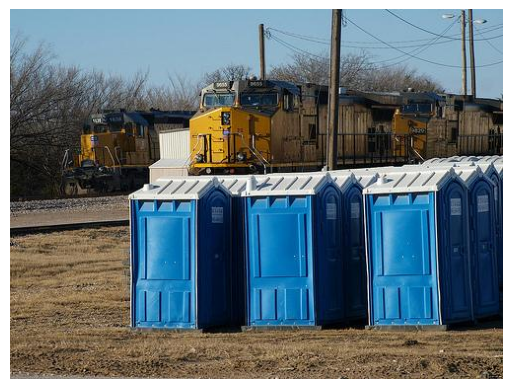


Original caption: There are some portable bathrooms sitting near a railroad track. There are some trains sitting on the track. The portable bathrooms are blue with a white roof and the trains are yellow.
Generated caption: 



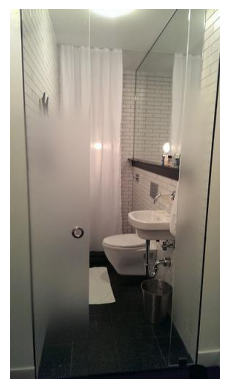


Original caption: A very white bathroom has a very white sink and toilet. The shower curtain that hangs from the ceiling is also white. There is one wall that is all mirrored. The door is made of glass and the faucet is silver. The floor is made of black tile. 
Generated caption: a bathroom with a white sink and a white sink. there is a white toilet on the floor next to the sink. there is a white toilet in front of the sink.



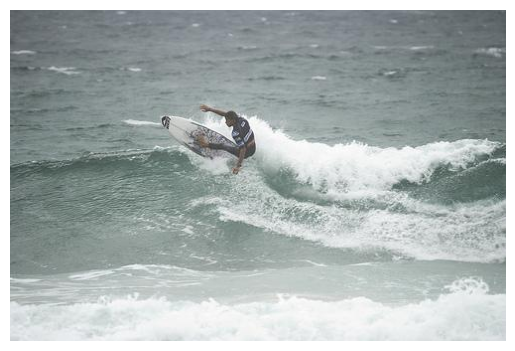


Original caption: A man is in a black wetsuit. The man is riding a white surfboard. There is a large wave in the water the man is surfing on. 
Generated caption: a man is surfing on a wave. the wave is white. the man is wearing a black shirt. the man is wearing a black helmet. the helmet is black. the man is wearing a black shirt. the man is wearing a black shirt. the water is splashing in the water. the water is white. there are waves in the water. there are waves in the water. there are waves in the water. there are waves in the water. there are waves in the water. there are waves in the water. there are waves in the water. there is a big wave in the water.



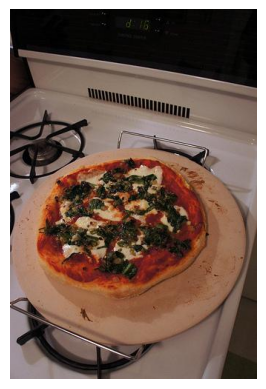


Original caption: A pizza is on a brown wooden tray. The tray is placed on the stove top. The pizza has melted cheese and spinach on top of it. The stove is white with black burners.
Generated caption: a pizza is on a wooden table. there is a white plate on the table. there is a pizza on top of the pizza.



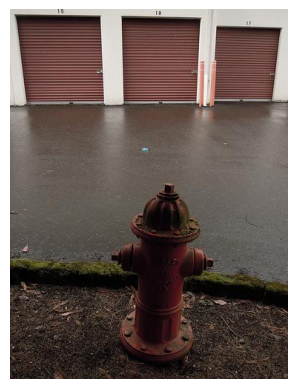


Original caption: a flood is occuring. there is a lot of water on the road. the hydrant on the sidewalk is red. the garage doors are red in color . there are some pieces of grass growing.
Generated caption: a fire hydrant is sitting on a sidewalk. the fire hydrant is red and has a blue handle. there is a red brick wall behind the fire hydrant.



In [55]:
# Show images along with captions geenrated
import matplotlib.pyplot as plt
import numpy as np

num_images = 20

for i in range(num_images):
  image_path = os.path.join(test_image_dir, test_labels.iloc[i,1])
  image = Image.open(image_path)

  # Display image
  plt.imshow(image)
  plt.axis('off')
  plt.show()
  print("\nOriginal caption: " + test_labels.iloc[i,2])
  print("Generated caption: " + test_labels.iloc[i,3] + '\n')


In [48]:
reference_captions = test_labels['caption'].tolist()
generated_captions = test_labels['Predictions'].tolist()
test_imgs = test_labels['filename'].tolist()

## Evaluating metrics

In [49]:
# # from rouge_score import rouge_scorer
# from pycocoevalcap.rouge.rouge import Rouge

# # rouge = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

# rougeL_precision = []
# rougeL_recall = []
# rougeL_f1 = []
# for reference, prediction in zip(reference_captions, generated_captions):
#     # Convert reference and prediction to strings if they are not already
#     reference = str(reference)
#     prediction = str(prediction)

#     scores = rouge.score(reference, prediction)
#     rougeL_scores = scores['rougeL']

#     rougeL_precision.append(rougeL_scores.precision)
#     rougeL_recall.append(rougeL_scores.recall)
#     rougeL_f1.append(rougeL_scores.fmeasure)

# average_rougeL_precision = sum(rougeL_precision) / len(rougeL_precision)
# average_rougeL_recall = sum(rougeL_recall) / len(rougeL_recall)
# average_rougeL_f1 = sum(rougeL_f1) / len(rougeL_f1)

# print("Average Rouge-L Precision:", average_rougeL_precision)
# print("Average Rouge-L Recall:", average_rougeL_recall)
# print("Average Rouge-L F1-score:", average_rougeL_f1)

In [58]:
# Installing necessary libraries
%%capture
!pip install pycocoevalcap
!pip install nltk

# Importing required modules
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice
from pycocoevalcap.rouge.rouge import Rouge

# Function to evaluate a model
def model_performance(model):
    # Importing necessary modules
    import torch

    # Checking for GPU availability
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initializing evaluation metrics
    cider_evaluator = Cider()
    spice_evaluator = Spice()
    rouge_evaluator = Rouge()

    # Switching to evaluation mode
    model.eval()

    # Defining data structures to store references and hypotheses
    reference_annotations = {}
    generated_annotations = {}

    with torch.no_grad():
        for i in range(len(test_imgs)):
            image_id = test_imgs[i]
            # Converting token IDs to words using Vocabulary

            if image_id not in reference_annotations:
                reference_annotations[image_id] = []
                generated_annotations[image_id] = []
            reference_annotations[image_id].append(reference_captions[i])
            generated_annotations[image_id].append(generated_captions[i])

    # Computing evaluation scores
    cider_score, _ = cider_evaluator.compute_score(reference_annotations, generated_annotations)
    spice_score, _ = spice_evaluator.compute_score(reference_annotations, generated_annotations)
    rouge_score, _ = rouge_evaluator.compute_score(reference_annotations, generated_annotations)

    return cider_score, spice_score, rouge_score

# Evaluating the model
cider_score, spice_score, rouge_score = model_performance(model)


In [59]:
# Printing evaluation scores
print("\nCIDEr Score:", cider_score)
print("SPICE Score:", spice_score)
print("ROUGE Score:", rouge_score)


CIDEr Score: 0.09611562590177923
SPICE Score: 0.12814811400282447
ROUGE Score: 0.20605297669022243
